In [79]:
%load_ext autoreload
%autoreload 2

import fd_imputer
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up all paths and labels needed in this notebook

In [80]:
DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/adult.csv'
SPLITS_PATH = 'MLFD_fd_detection/data/'
METANOME_DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/'
FD_PATH = 'MLFD_fd_detection/results/HyFD-1.2-SNAPSHOT.jar2019-05-07T082200_fds'
DATA_TITLE = 'adult'

In [81]:
df_train = pd.read_csv(SPLITS_PATH+'test/'+DATA_TITLE+'_test.csv', header=None)
df_test = pd.read_csv(SPLITS_PATH+'train/'+DATA_TITLE+'_train.csv', header=None)
fds = fd_imputer.read_fds(FD_PATH)
impute_column = str(9)
df_test = df_test.replace('noValueSetHere123156456', np.nan)
df_train = df_train.replace('noValueSetHere123156456', np.nan)

In [40]:
fds[9][1]

[11, 12, 13, 3, 7, 8]

## FD_Imputer

### Getting metrics for all FDs in adult.csv

In [26]:
from sklearn import metrics 

In [75]:
fd_imputer_results = {}
for rhs in fds:
    results = []
    for lhs in fds[rhs]:
        print(rhs, lhs)
        fd = {rhs: lhs}
        df_fd_imputed = fd_imputer.fd_imputer(df_test, df_train, fd)
        
        # make sure that value for missing data is of same type as row to be imputed
        # to avoid mix of labels with scikit.metrics
        if isinstance(df_fd_imputed.loc[0, rhs], str):
            df_fd_imputed = df_fd_imputed.fillna('no value')
        else:
            df_fd_imputed = df_fd_imputed.fillna(99999999)
            
        y_pred = df_fd_imputed.loc[:, str(rhs)+'_imputed']
        y_true = df_fd_imputed.loc[:, rhs]
        result = {
            'lhs': lhs,
            'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
            'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
            'f1': metrics.f1_score(y_true, y_pred, average='weighted')
        }
        results.append(result)
    fd_imputer_results[rhs] = results

3 [0]
11 [0]
13 [0]
12 [0]
12 [13, 1, 2, 3, 4, 7]
12 [13, 1, 3, 4, 6, 7]
12 [13, 1, 3, 4, 7, 8]
12 [13, 1, 2, 3, 5, 7]
12 [13, 1, 3, 5, 6, 7]
12 [13, 1, 3, 5, 7, 8]
1 [0]
14 [0]
4 [0]
4 [5]
5 [0]
5 [4]
7 [0]
2 [0]
6 [0]
6 [11, 13, 1, 3, 7, 8]
6 [13, 1, 3, 4, 7, 8]
6 [13, 1, 3, 5, 7, 8]
8 [0]
9 [0]


KeyboardInterrupt: 

In [80]:
precision = [e['precision'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
recall = [e['recall'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
f1 = [e['f1'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
rhs_color = [rhs for rhs in fd_imputer_results 
           for e in fd_imputer_results[rhs]]

area = [x*4000 for x in f1]
colormap = plt.cm.get_cmap('RdYlBu')

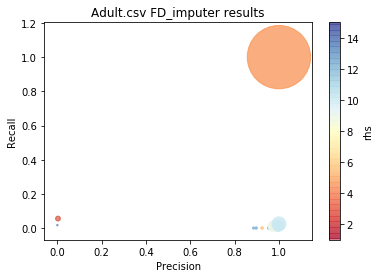

In [86]:
fig, ax = plt.subplots()
sc = plt.scatter(precision, 
                 recall, 
                 cmap=colormap,
                 c=rhs_color, 
                 s=area, 
                 alpha=0.5)
plt.colorbar(sc, label='rhs')
ax.set(title='Adult.csv FD_imputer results',
      xlabel = 'Precision',
      ylabel = 'Recall')
fig.savefig('fd_imputer_performance.png', transparent=False,
           dpi=320, bbox_inches='tight')

## ML imputation on fd's

In [82]:
ml_imputer_results = {}
for rhs in fds:
    results = []
    for lhs in fds[rhs]:
        relevant_cols = lhs + [rhs]
        df_imputed = fd_imputer.ml_imputer(df_train.iloc[:,relevant_cols], 
                                           df_test.iloc[:,relevant_cols], 
                                           rhs)
        # make sure that value for missing data is of same type as row to be imputed
        # to avoid mix of labels with scikit.metrics
        #if isinstance(df_imputed.loc[0, rhs], str):
        #    df_imputed = df_imputed.fillna('no value')
        #else:
        #    df_imputed = df_imputed.fillna(99999999)
        y_pred = df_imputed.loc[:, str(rhs)+'_imputed']
        y_true = df_imputed.loc[:, str(rhs)]

        result = {
        'lhs': lhs,
        'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
        'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
        'f1': metrics.f1_score(y_true, y_pred, average='weighted')
        }
        results.append(result)
    ml_imputer_results[rhs] = results

2019-06-04 10:40:43,401 [INFO]  
========== start: fit model
2019-06-04 10:40:43,402 [WARNING]  Already bound, ignoring bind()
2019-06-04 10:40:43,634 [INFO]  Epoch[0] Batch [0-184]	Speed: 13057.04 samples/sec	cross-entropy=0.361279	3-accuracy=0.000000
2019-06-04 10:40:43,866 [INFO]  Epoch[0] Train-cross-entropy=0.182501
2019-06-04 10:40:43,868 [INFO]  Epoch[0] Train-3-accuracy=0.000000
2019-06-04 10:40:43,870 [INFO]  Epoch[0] Time cost=0.465
2019-06-04 10:40:43,877 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-04 10:40:43,918 [INFO]  Epoch[0] Validation-cross-entropy=0.000634
2019-06-04 10:40:43,920 [INFO]  Epoch[0] Validation-3-accuracy=0.000000
2019-06-04 10:40:44,200 [INFO]  Epoch[1] Batch [0-184]	Speed: 10943.29 samples/sec	cross-entropy=0.000731	3-accuracy=0.000000
2019-06-04 10:40:44,464 [INFO]  Epoch[1] Train-cross-entropy=0.000505
2019-06-04 10:40:44,466 [INFO]  Epoch[1] Train-3-accuracy=0.000000
2019-06-04 10:40:44,468 [INFO]  Epoch[1] Time cost=0.541


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

### Manual fd detection using fd_imputer.fd_imputer

In [11]:
#fd = {9: [3, 4, 7, 8]}
fd = {4: [5]} # this fd creates a memory error if no drop_duplicates
rhs = list(fd)[0]
lhs = fd[rhs]
relevant_cols = lhs.copy()
relevant_cols.append(rhs)

In [49]:
df_fd_imputed = fd_imputer.fd_imputer(df_test, df_train, fd)
df_fd_imputed = df_fd_imputed.fillna('no value')

In [22]:
y_pred = df_fd_imputed.loc[:, '9_imputed']
y_true = df_fd_imputed.iloc[:, 9]
print(metrics.precision_score(y_true, y_pred, average='weighted'))
print(metrics.recall_score(y_true, y_pred, average='weighted'))
print(metrics.f1_score(y_true, y_pred, average='weighted'))

KeyError: '9_imputed'

## 1. How to split the dataset

In [ ]:
df = pd.read_csv(DATA_PATH, sep=';', header=None)
fd_imputer.save_df_split(DATA_TITLE, df, SPLITS_PATH, METANOME_DATA_PATH, [0.8, 0.2])

## 2. How to use the ML-imputer

Impute test-set

In [49]:
df_train.iloc[:, :-2].head()
#df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,22855,23,Private,113309,Some-college,10,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40
1,18912,24,NaN,412156,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,40
2,17454,51,Private,139347,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,7688,0,40
3,14966,20,Private,223811,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40
4,12289,40,Self-emp-not-inc,48859,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32


In [86]:
df_imputed = fd_imputer.ml_imputer(df_train.iloc[:,[4,5]], 
                                   df_test.iloc[:,[4,5]],
                                   5)

2019-06-04 11:22:30,600 [INFO]  
========== start: fit model
2019-06-04 11:22:30,602 [WARNING]  Already bound, ignoring bind()
2019-06-04 11:22:32,287 [INFO]  Epoch[0] Batch [0-184]	Speed: 1763.98 samples/sec	cross-entropy=0.350771	5-accuracy=0.000000
2019-06-04 11:22:33,904 [INFO]  Epoch[0] Train-cross-entropy=0.176974
2019-06-04 11:22:33,907 [INFO]  Epoch[0] Train-5-accuracy=0.000000
2019-06-04 11:22:33,909 [INFO]  Epoch[0] Time cost=3.304
2019-06-04 11:22:33,913 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-04 11:22:34,267 [INFO]  Epoch[0] Validation-cross-entropy=0.000048
2019-06-04 11:22:34,269 [INFO]  Epoch[0] Validation-5-accuracy=0.000000
2019-06-04 11:22:35,904 [INFO]  Epoch[1] Batch [0-184]	Speed: 1821.23 samples/sec	cross-entropy=0.000005	5-accuracy=0.000000
2019-06-04 11:22:37,533 [INFO]  Epoch[1] Train-cross-entropy=0.000003
2019-06-04 11:22:37,931 [INFO]  Epoch[1] Train-5-accuracy=0.000000
2019-06-04 11:22:37,936 [INFO]  Epoch[1] Time cost=3.662
20

In [87]:
df_imputed.head()

,4,5,5_imputed
0,HS-grad,9,9.0
1,HS-grad,9,9.0
2,Assoc-voc,11,11.0
3,Some-college,10,10.0
4,Prof-school,15,15.0


In [ ]:
f1 = f1_score(df_imputed[impute_column], df_imputed[impute_column+'_imputed'].astype(int), average='weighted')
print(f1)

The ML model's mean relative error is roughly 0.2%

In [ ]:
average_rel_error = ((df_imputed[impute_column] - df_imputed[impute_column+'_imputed'])
 / df_imputed[impute_column]).mean()
print(average_rel_error)